<a href="https://colab.research.google.com/github/mahn-bonnie/Machine-Learning/blob/main/HeartDiseasePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hearts-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4513706%2F7725965%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T084556Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D54c6082ad49171f2bc78f344b428a1f9bb616142b1ff5d2e40f4459724ace1257bb18f2460c4f497d65591e339b495dad4eac411719310eec89e9b21e51aa80157fff29d2fec8a76f55abe8cf471d321258b17fd81213bdac7c21eded8b39a4cafdd32b91cd906f031b1364062f3bdb9f593b1bcfcf8547f13d425edab83ee45fec17f14dbf78d4a9caf817bae795a032cc319c3fe3d45617039b9342af8df792467266c4b406f28f26bc61f7a5cd1d184ba6d5fef420f5249b5855978f13f1151749fa2c41f9185a17c3ff32355e17e8555ab8b262ef38076b61680e7764243d558d4e2c2bb61b1df5a0695f1b58e7b12c82703c533129c97d190e90346ba7d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6325 bytes downloaded
Downloaded and uncompressed: hearts-csv
Data source import complete.


# **Importing Libraries**

In [4]:
import pandas as pd

# **Importing the dataset**

In [5]:
data = pd.read_csv('/kaggle/input/hearts-csv/heart.csv')

In [6]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


# **Taking care of values**

In [7]:
data.isnull()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1021,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1022,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1023,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# **Duplicate Values**

In [9]:
data_dup = data.duplicated().any()

In [10]:
data_dup

True

In [11]:
data = data.drop_duplicates()

In [12]:
data_dup = data.duplicated().any()

In [13]:
data_dup

False

# **Data Processing**

In [14]:
cate_val = []

In [15]:
count_val = []

In [16]:
for column in data.columns:
    if data[column].nunique() <= 10:
        cate_val.append(column)
    else:
        count_val.append(column)

In [17]:
cate_val

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [18]:
count_val

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# **Encoding Categorical Data**

In [19]:
cate_val

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [20]:
data['cp'].unique()

array([0, 1, 2, 3])

In [21]:
cate_val.remove('sex')
cate_val.remove('target')
data = pd.get_dummies(data,columns = cate_val,drop_first=True)

In [22]:
data.head()

,age,sex,trestbps,chol,thalach,oldpeak,target,cp_1,cp_2,cp_3,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,52,1,125,212,168,1.0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,53,1,140,203,155,3.1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,70,1,145,174,125,2.6,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,61,1,148,203,161,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4,62,0,138,294,106,1.9,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


# **Feature Scaling**

In [23]:
data.head()

,age,sex,trestbps,chol,thalach,oldpeak,target,cp_1,cp_2,cp_3,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,52,1,125,212,168,1.0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,53,1,140,203,155,3.1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,70,1,145,174,125,2.6,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,61,1,148,203,161,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4,62,0,138,294,106,1.9,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
st = StandardScaler()
data[count_val] = st.fit_transform(data[count_val])

In [26]:
data.head()

,age,sex,trestbps,chol,thalach,oldpeak,target,cp_1,cp_2,cp_3,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,-0.267966,1,-0.376556,-0.667728,0.806035,-0.037124,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,-0.157260,1,0.478910,-0.841918,0.237495,1.773958,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1.724733,1,0.764066,-1.403197,-1.074521,1.342748,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.728383,1,0.935159,-0.841918,0.499898,-0.899544,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4,0.839089,0,0.364848,0.919336,-1.905464,0.739054,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


# **Splitting The Dataset Into The Training Set And Test Set**

In [27]:
X = data.drop('target',axis=1)

In [28]:
y = data['target']

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42)

In [31]:
y_test

245    1
349    0
135    0
389    1
66     1
      ..
402    1
123    1
739    0
274    1
256    1
Name: target, Length: 61, dtype: int64

# **Logistic Regression**

In [32]:
data.head()

,age,sex,trestbps,chol,thalach,oldpeak,target,cp_1,cp_2,cp_3,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,-0.267966,1,-0.376556,-0.667728,0.806035,-0.037124,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,-0.157260,1,0.478910,-0.841918,0.237495,1.773958,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1.724733,1,0.764066,-1.403197,-1.074521,1.342748,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.728383,1,0.935159,-0.841918,0.499898,-0.899544,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4,0.839089,0,0.364848,0.919336,-1.905464,0.739054,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
log = LogisticRegression()
log.fit(X_train,y_train)

LogisticRegression()

In [35]:
y_pred1 = log.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy_score(y_test,y_pred1)

0.7868852459016393

# **SVC**

In [38]:
from sklearn import svm

In [39]:
svm = svm.SVC()

In [40]:
svm.fit(X_train,y_train)

SVC()

In [41]:
y_pred2 = svm.predict(X_test)

In [42]:
accuracy_score(y_test,y_pred2)

0.8032786885245902

# **KNeighbors Classifier**

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
knn = KNeighborsClassifier()

In [45]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [46]:
y_pred3=knn.predict(X_test)

In [47]:
accuracy_score(y_test,y_pred3)

0.7377049180327869

In [48]:
score = []

for k in range(1,40):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    score.append(accuracy_score(y_test,y_pred))

In [49]:
score

[0.7213114754098361,
 0.8032786885245902,
 0.7049180327868853,
 0.7049180327868853,
 0.7377049180327869,
 0.8032786885245902,
 0.7868852459016393,
 0.8032786885245902,
 0.7704918032786885,
 0.7540983606557377,
 0.7704918032786885,
 0.7540983606557377,
 0.7377049180327869,
 0.7377049180327869,
 0.7540983606557377,
 0.7704918032786885,
 0.7540983606557377,
 0.7540983606557377,
 0.7377049180327869,
 0.7540983606557377,
 0.7377049180327869,
 0.7213114754098361,
 0.7377049180327869,
 0.7377049180327869,
 0.7213114754098361,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869]

In [50]:
import matplotlib.pyplot as plt

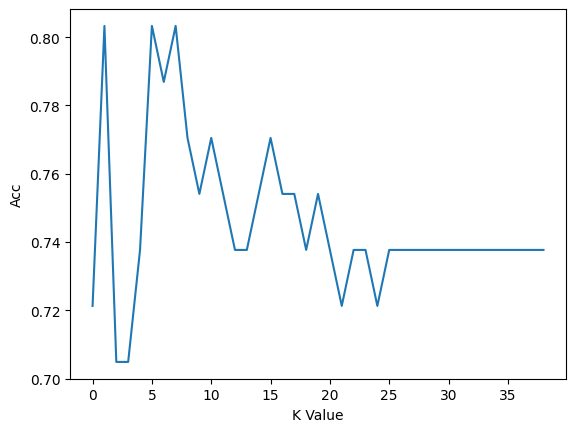

In [51]:
plt.plot(score)
plt.xlabel("K Value")
plt.ylabel("Acc")
plt.show()

In [52]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
accuracy_score(y_test,y_pred)

0.8032786885245902

# **Non-Linear ML Algorithms**

In [53]:
data = pd.read_csv('/kaggle/input/hearts-csv/heart.csv')

In [54]:
data = data.drop_duplicates()

In [55]:
X = data.drop('target',axis=1)
y=data['target']

In [56]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,
                                                random_state=42)

# **Decision Tree Classifier**

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [58]:
dt = DecisionTreeClassifier()

In [59]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [60]:
y_pred4= dt.predict(X_test)

In [61]:
accuracy_score(y_test,y_pred4)

0.7213114754098361

# **Random Forest Classifier**

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rf = RandomForestClassifier()

In [64]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [65]:
y_pred5= rf.predict(X_test)

In [66]:
accuracy_score(y_test,y_pred5)

0.8360655737704918

# **Gradient Boosting Classifier**

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

In [68]:
gbc = GradientBoostingClassifier()

In [69]:
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

In [70]:
y_pred6 = gbc.predict(X_test)

In [71]:
accuracy_score(y_test,y_pred6)

0.8032786885245902

In [72]:
final_data = pd.DataFrame({'Models':['LR','SVM','KNN','DT','RF','GB'],
                          'ACC':[accuracy_score(y_test,y_pred1)*100,
                                accuracy_score(y_test,y_pred2)*100,
                                accuracy_score(y_test,y_pred3)*100,
                                accuracy_score(y_test,y_pred4)*100,
                                accuracy_score(y_test,y_pred5)*100,
                                accuracy_score(y_test,y_pred6)*100]})

In [73]:
final_data

,Models,ACC
0,LR,78.688525
1,SVM,80.327869
2,KNN,73.770492
3,DT,72.131148
4,RF,83.606557
5,GB,80.327869


In [74]:
import seaborn as sns

<Axes: xlabel='Models', ylabel='ACC'>

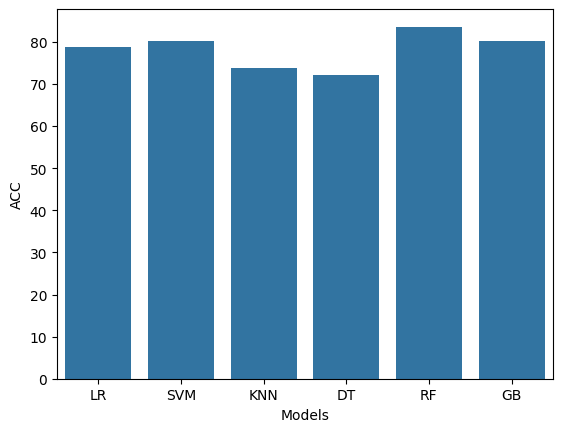

In [75]:
sns.barplot(x=final_data['Models'],y=final_data['ACC'])

In [76]:
X=data.drop('target',axis=1)
y=data['target']

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rf = RandomForestClassifier()
rf.fit(X,y)

RandomForestClassifier()

# **Prediction on New Data**

In [79]:
import pandas as pd

In [80]:
new_data = pd.DataFrame({
    'age':52,
    'sex':1,
    'cp':0,
    'trestbps':125,
    'chol':212,
    'fbs':0,
    'restecg':1,
    'thalach':168,
    'exang':0,
    'oldpeak':1.0,
     'slope':2,
    'ca':2,
    'thal':3,
},index=[0])

In [81]:
new_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3


In [82]:
p = rf.predict(new_data)
if p[0]==0:
    print("No Disease")
else:
    print("Disease")

No Disease


# **Save Model Using Joblib**

In [83]:
import joblib

In [84]:
joblib.dump(rf,'model_joblib_heart')

['model_joblib_heart']

In [85]:
['model_joblib_heart']

['model_joblib_heart']

In [86]:
model = joblib.load('model_joblib_heart')

In [87]:
model.predict(new_data)

array([0])

In [88]:
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
723,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1
733,44,0,2,108,141,0,1,175,0,0.6,1,0,2,1
739,52,1,0,128,255,0,1,161,1,0.0,2,1,3,0
843,59,1,3,160,273,0,0,125,0,0.0,2,0,2,0
878,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


# **GUI**

In [89]:
from tkinter import *
import joblib

In [90]:
from tkinter import *
import joblib
import numpy as np
from sklearn import *
def show_entry_fields():
    p1=int(e1.get())
    p2=int(e2.get())
    p3=int(e3.get())
    p4=int(e4.get())
    p5=int(e5.get())
    p6=int(e6.get())
    p7=int(e7.get())
    p8=int(e8.get())
    p9=int(e9.get())
    p10=float(e10.get())
    p11=int(e11.get())
    p12=int(e12.get())
    p13=int(e13.get())
    model = joblib.load('model_joblib_heart')
    result=model.predict([[p1,p2,p3,p4,p5,p6,p7,p8,p8,p10,p11,p12,p13]])

    if result == 0:
        Label(master, text="No Heart Disease").grid(row=31)
    else:
        Label(master, text="Possibility of Heart Disease").grid(row=31)


master = Tk()
master.title("Heart Disease Prediction System")


label = Label(master, text = "Heart Disease Prediction System"
                          , bg = "black", fg = "white"). \
                               grid(row=0,columnspan=2)


Label(master, text="Enter Your Age").grid(row=1)
Label(master, text="Male Or Female [1/0]").grid(row=2)
Label(master, text="Enter Value of CP").grid(row=3)
Label(master, text="Enter Value of trestbps").grid(row=4)
Label(master, text="Enter Value of chol").grid(row=5)
Label(master, text="Enter Value of fbs").grid(row=6)
Label(master, text="Enter Value of restecg").grid(row=7)
Label(master, text="Enter Value of thalach").grid(row=8)
Label(master, text="Enter Value of exang").grid(row=9)
Label(master, text="Enter Value of oldpeak").grid(row=10)
Label(master, text="Enter Value of slope").grid(row=11)
Label(master, text="Enter Value of ca").grid(row=12)
Label(master, text="Enter Value of thal").grid(row=13)



e1 = Entry(master)
e2 = Entry(master)
e3 = Entry(master)
e4 = Entry(master)
e5 = Entry(master)
e6 = Entry(master)
e7 = Entry(master)
e8 = Entry(master)
e9 = Entry(master)
e10 = Entry(master)
e11 = Entry(master)
e12 = Entry(master)
e13 = Entry(master)

e1.grid(row=1, column=1)
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1)
e5.grid(row=5, column=1)
e6.grid(row=6, column=1)
e7.grid(row=7, column=1)
e8.grid(row=8, column=1)
e9.grid(row=9, column=1)
e10.grid(row=10, column=1)
e11.grid(row=11, column=1)
e12.grid(row=12, column=1)
e13.grid(row=13, column=1)



Button(master, text='Predict', command=show_entry_fields).grid()

mainloop()

TclError: no display name and no $DISPLAY environment variable